# IMPORTATION DES BIBLIOTHEQUES

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from  sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)
import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Chargement des données
data = pd.read_csv('Dataset_Reponse_Marketing.csv')  

In [3]:
# Affichage des premières lignes
print(data.head())

   Age   Sexe  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  \
0   22  Homme          40124             16.518974                9   
1   32  Femme          26307             21.973535                8   
2   28  Femme          30040             26.762915                9   
3   16  Femme          15843             29.046008                9   
4   45  Homme          20225             21.479944                5   

   Reponse_campagne  
0                 1  
1                 1  
2                 1  
3                 0  
4                 0  


In [4]:
# Informations sur les données
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   2400 non-null   int64  
 1   Sexe                  2400 non-null   object 
 2   Revenu_annuel         2400 non-null   int64  
 3   Temps_passe_sur_site  2400 non-null   float64
 4   Achats_en_ligne       2400 non-null   int64  
 5   Reponse_campagne      2400 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 112.6+ KB
None


In [5]:
# Vérification des valeurs manquantes
print(data.isnull().sum())

Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64


In [6]:
# Statistiques descriptives
print(data.describe())

               Age  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  \
count  2400.000000    2400.000000           2400.000000      2400.000000   
mean     34.611250   26197.005000             22.073762         7.642083   
std      10.087287    7062.015627              3.993837         1.612471   
min      -1.000000    4422.000000              8.656394         2.000000   
25%      28.000000   21414.250000             19.381206         7.000000   
50%      35.000000   26222.000000             22.072839         8.000000   
75%      42.000000   30909.250000             24.798229         9.000000   
max      79.000000   50002.000000             37.769324        13.000000   

       Reponse_campagne  
count       2400.000000  
mean           0.526250  
std            0.499415  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%            1.000000  
max            1.000000  


# 1. Exploration des données et visualisation

<Axes: xlabel='Reponse_campagne', ylabel='count'>

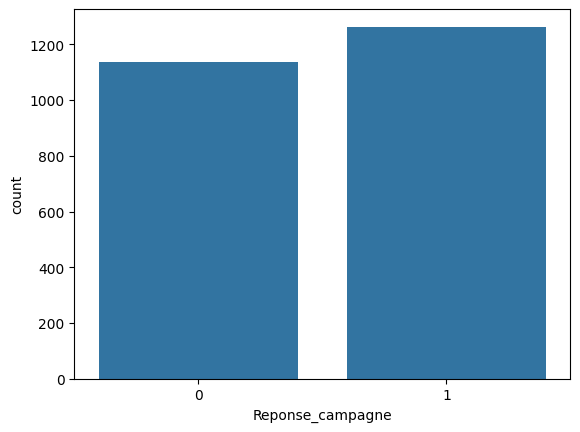

In [7]:
# Barplot
sns.countplot(data=data, x='Reponse_campagne')

In [8]:
data["Reponse_campagne"].value_counts(dropna=False)

Reponse_campagne
1    1263
0    1137
Name: count, dtype: int64

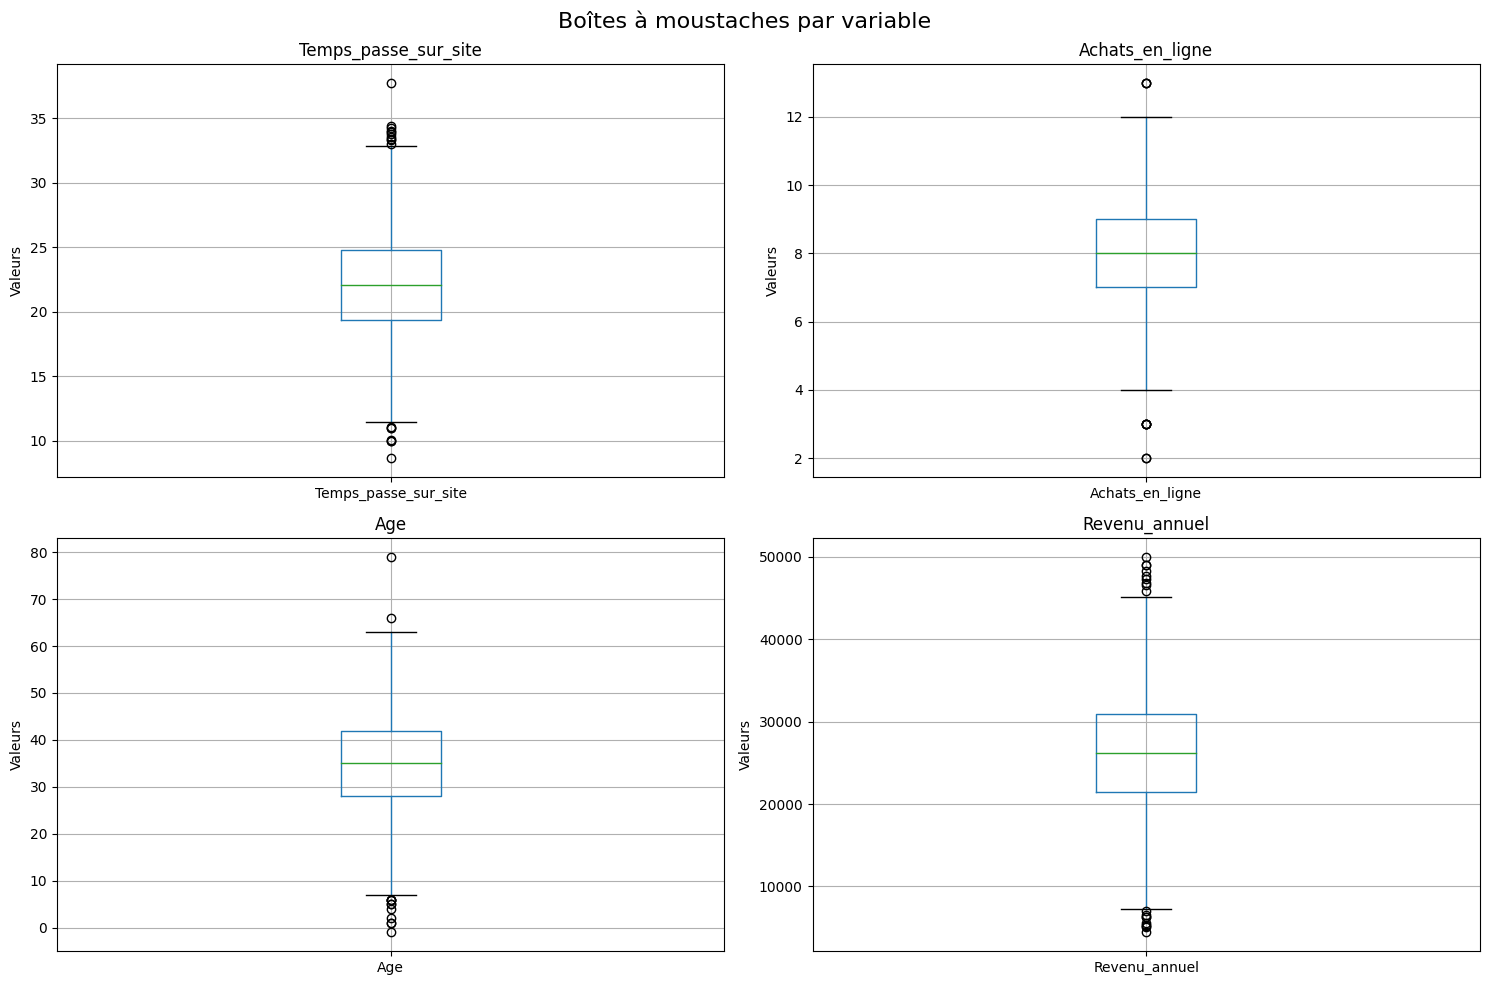

In [9]:
variables = ['Temps_passe_sur_site', 'Achats_en_ligne', 'Age', 'Revenu_annuel']

# Configuration des subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
fig.suptitle("Boîtes à moustaches par variable", fontsize=16)

# Génération des boxplots individuels
for ax, variable in zip(axes.flatten(), variables):
    data.boxplot(column=variable, ax=ax)
    ax.set_title(variable)
    ax.set_ylabel('Valeurs')

# Ajustement de l'espacement
plt.tight_layout()
plt.show()

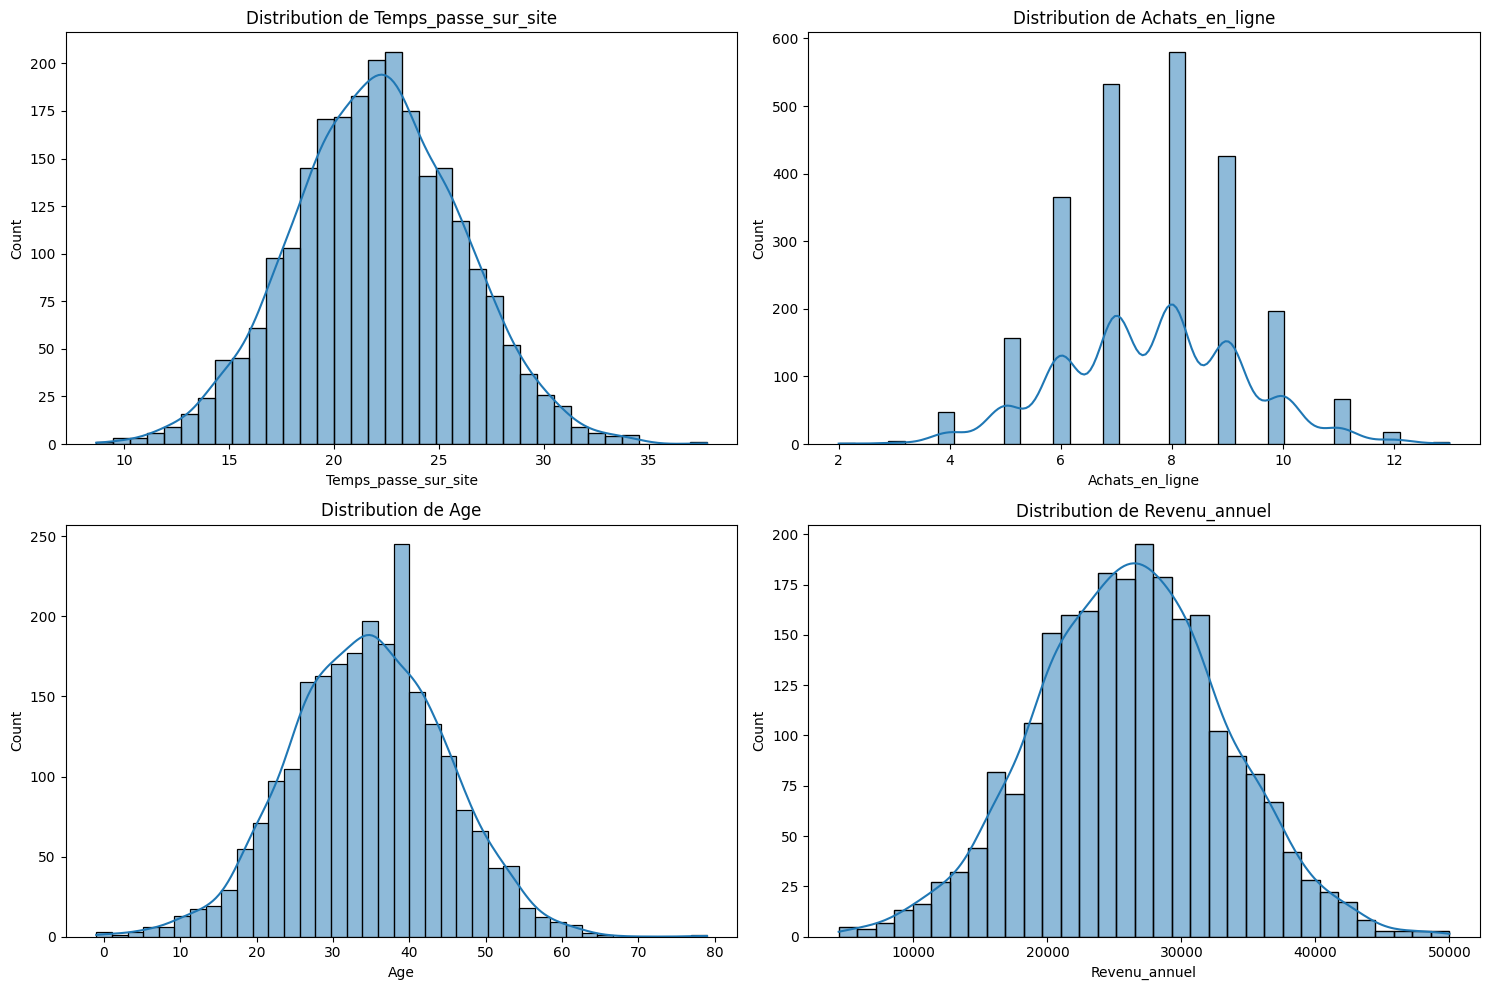

In [10]:
# Vérification de la distribution des variables
numeric_cols=['Temps_passe_sur_site', 'Achats_en_ligne', 'Age', 'Revenu_annuel']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

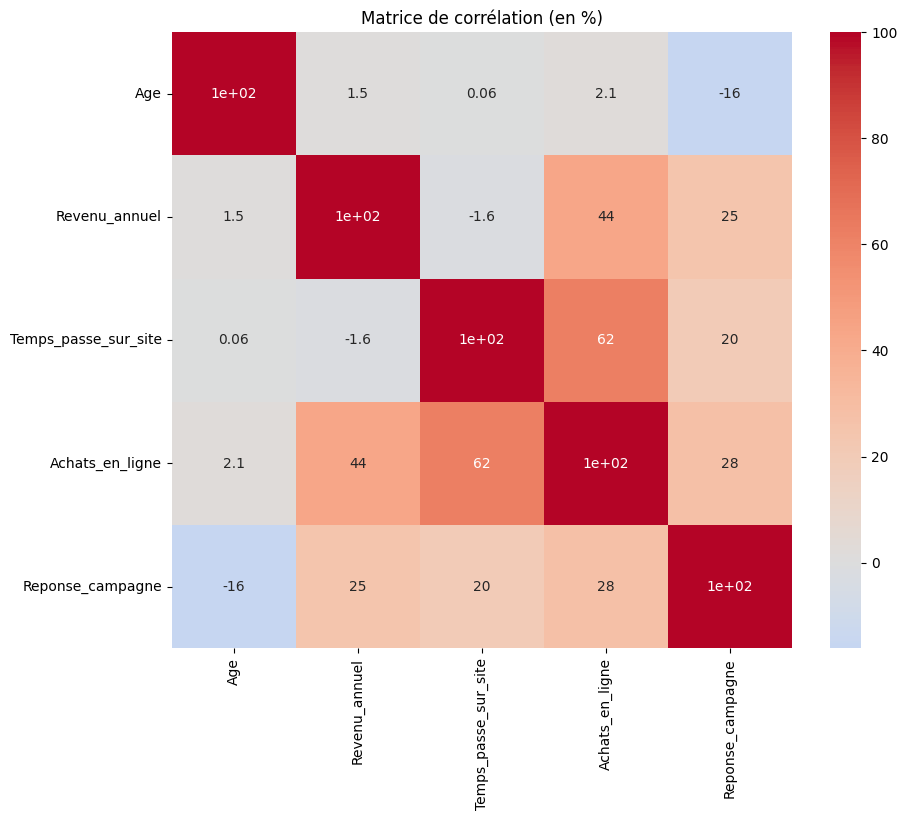

In [11]:
corr_matrix = round(data.drop(columns=['Sexe']).corr()*100,2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation (en %)')
plt.show()

Nous constatons qu'il y a une forte correlation entre Achats_en_ligne et Temps_passe_sur_site, donc plus l'on passe le temps sur le site mieux plus on effectue les achats

In [12]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# Exclure la variable cible et appliquer sur les features numériques
vif_results = calculate_vif(data[['Temps_passe_sur_site', 'Achats_en_ligne', 'Age', 'Revenu_annuel']])
print(vif_results)

               Variable        VIF
0  Temps_passe_sur_site  39.853741
1       Achats_en_ligne  55.420301
2                   Age  10.250709
3         Revenu_annuel  17.256689


Nous avons assez de preuves pour affirmer qu'il existe une multicolinéarité entre les variables explicatives (VIF > 10), alors une transformation par l'ACP est nécessaire pour supprimer cet effet.

# 2. Prétraitement des données

In [13]:
# Gestion de la variable catégorielle
data = pd.get_dummies(data, columns=['Sexe'], drop_first=True)

In [14]:
#  Diviser les données 
X = data.drop('Reponse_campagne', axis=1)
y = data['Reponse_campagne']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [15]:
# Remplacer les âges trop faibles (incapables de participer à une campagne) par l'âge médian
median_age = X_train['Age'].median() # On utilise seulement X_train pour calculer la médiane pour éviter la fuite des données
data.loc[data['Age'] < 15, 'Age'] = median_age

In [16]:
# Mise à l'échelle pour faire une ACP
scaler = RobustScaler() # RobustScaler est privilégié car nous avons remarqué la présence d'outliers
scaler = scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Transformation factorielle
pca = PCA()
pca.fit(X_train_scaled)
pca_train_scaled=pca.transform(X_train_scaled)
pca_test_scaled=pca.transform(X_test_scaled)

# Remarque : l'ajustement se fait seulement sur la base d'entraînement, objectif : ne pas créer une fuite de données

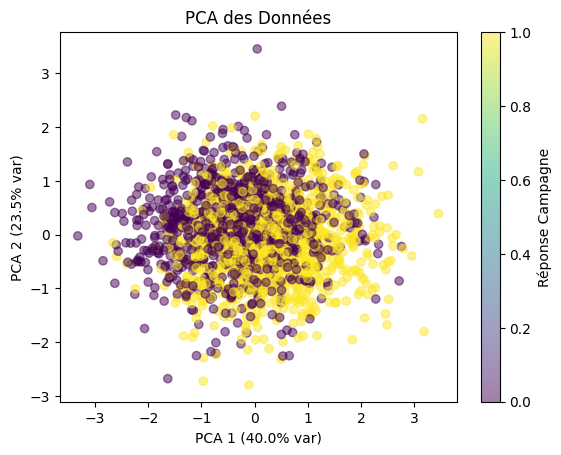

In [17]:
# Visualisation de l'ACP avec les deux premières composantes
plt.scatter(pca_train_scaled[:, 0], pca_train_scaled[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.xlabel('PCA 1 ({}% var)'.format(round(pca.explained_variance_ratio_[0]*100, 1)))
plt.ylabel('PCA 2 ({}% var)'.format(round(pca.explained_variance_ratio_[1]*100, 1)))
plt.title('PCA des Données')
plt.colorbar(label='Réponse Campagne')
plt.show()

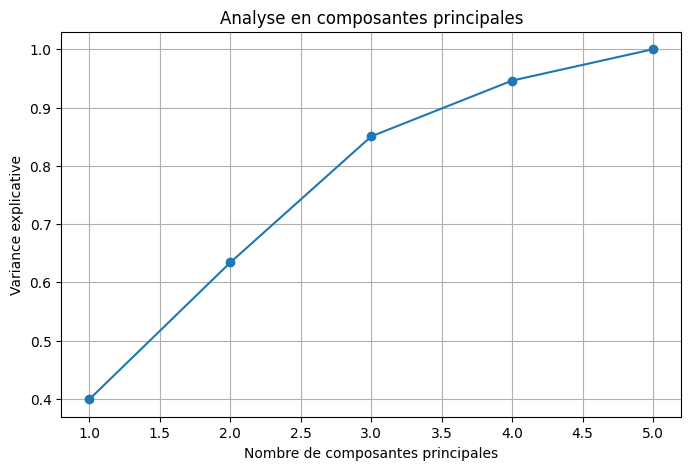

In [18]:
# Variance expliquée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance explicative')
plt.title('Analyse en composantes principales')
plt.grid()
plt.show()

Ici, l'objectif de l'ACP était de supprimer la corrélation (et multicolinéarité) entre les variables, les modèles seront alors beaucoup plus stables.

In [19]:
# Enregistrement de la base de donnée apres traitement
df_train = pd.DataFrame(pca_train_scaled, columns=[f'Composante_{i+1}' for i in range(pca_train_scaled.shape[1])])
df_test  = pd.DataFrame(pca_test_scaled, columns=[f'Composante_{i+1}' for i in range(pca_test_scaled.shape[1])])

# Rassemblement des variables explicatives mis à l'échelle
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

# Ajout de la variable cible
y = pd.DataFrame(y).reset_index(drop=True)
df = pd.concat([df, y], axis=1)

print(df)

      Composante_1  Composante_2  Composante_3  Composante_4  Composante_5  \
0        -0.253434      1.557362      0.301698      0.461180     -0.137656   
1         0.070243      0.864862     -0.225222      0.475596      0.222512   
2        -0.656174     -0.870087      0.668772      0.544961      0.226014   
3         1.182659     -0.114169      0.488571      0.515678     -0.320044   
4         1.369411      0.755290      0.188755      0.483441     -0.499207   
...            ...           ...           ...           ...           ...   
2395     -0.867019     -1.086438      0.079403      0.545320     -0.302118   
2396     -0.162171      0.094083      0.633659     -0.487488     -0.299709   
2397     -0.638874      0.949034     -0.494157     -0.530157      0.271235   
2398     -0.583312      1.498157      0.339589      0.464732     -0.522076   
2399      0.099763      1.453285     -1.237480     -0.557528      0.206125   

      Reponse_campagne  
0                    1  
1            

# 3.Choix d’un ou plusieurs modèles de classification

### 3.1 RandomForest

In [20]:
# Redivision des données (sans shuffle pour garder l'ordre défini par l'ancien split)
X = data.drop('Reponse_campagne', axis=1)
y = data['Reponse_campagne']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [21]:
# Initialisation
rf = RandomForestClassifier(random_state=42)  

# Entraînement
rf.fit(X_train, y_train)

# Prédiction et évaluation
y_pred_rf = rf.predict(X_test)
print("=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(classification_report(y_test, y_pred_rf))

print("\n📊 Métriques Clés :")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision (Classe 1): {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall (Sensibilité - Classe 1): {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score (Classe 1): {f1_score(y_test, y_pred_rf):.4f}")

=== Random Forest ===
Accuracy: 0.658
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       236
           1       0.65      0.70      0.68       244

    accuracy                           0.66       480
   macro avg       0.66      0.66      0.66       480
weighted avg       0.66      0.66      0.66       480


📊 Métriques Clés :
Accuracy: 0.6583
Precision (Classe 1): 0.6527
Recall (Sensibilité - Classe 1): 0.7008
F1-Score (Classe 1): 0.6759


# XGBOOT

In [22]:
# Initialisation (scale_pos_weight pour gérer le déséquilibre)
ratio_classes = sum(y == 0) / sum(y == 1)
xgb = XGBClassifier(random_state=42, scale_pos_weight=ratio_classes, eval_metric='logloss')

# Entraînement
xgb.fit(X_train, y_train)

# Prédiction
y_pred_xgb = xgb.predict(X_test)

# === Métriques de Performance ===
print("=== XGBoost ===")
print("\n🔍 Rapport de Classification :")
print(classification_report(y_test, y_pred_xgb))

print("\n📊 Métriques Clés :")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision (Classe 1): {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall (Sensibilité - Classe 1): {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score (Classe 1): {f1_score(y_test, y_pred_xgb):.4f}")

=== XGBoost ===

🔍 Rapport de Classification :
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       236
           1       0.64      0.66      0.65       244

    accuracy                           0.64       480
   macro avg       0.64      0.64      0.64       480
weighted avg       0.64      0.64      0.64       480


📊 Métriques Clés :
Accuracy: 0.6396
Precision (Classe 1): 0.6414
Recall (Sensibilité - Classe 1): 0.6598
F1-Score (Classe 1): 0.6505


K-NN

In [23]:
# KNN sur données après PCA
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)  

# Évaluation
y_pred = knn.predict(X_test)
print("Accuracy (avec PCA) :", knn.score(X_test, y_test))

Accuracy (avec PCA) : 0.5520833333333334


c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\uti

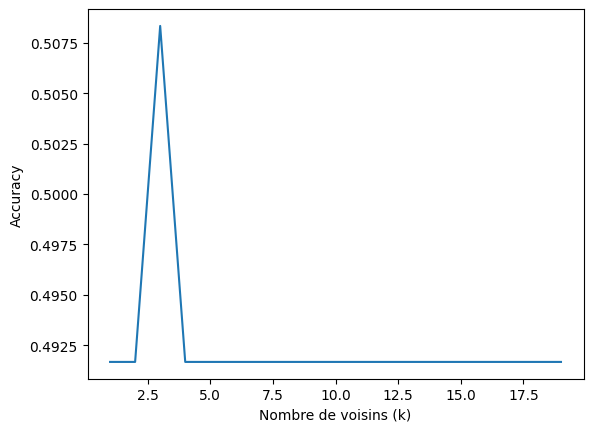

In [24]:
k_values = numpy.arange(1, 20)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)  # Nouvelle instance à chaque itération
    knn.fit(X_train, y_train)
    accuracies.append(knn.score(pca_test_scaled, y_test))

plt.plot(k_values, accuracies)
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Accuracy')
plt.show()

# 4.Évaluation des performances

In [25]:
#  Prédictions
knn = KNeighborsClassifier(n_neighbors=3)
model=knn.fit(X_train, y_train)  
y_pred = model.predict(X_test)

print("\n--- Métriques de Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall (Sensibilité):", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))


--- Métriques de Performance ---
Accuracy: 0.5708333333333333
Recall (Sensibilité): 0.6352459016393442
Precision: 0.5698529411764706
F1-Score: 0.6007751937984496



--- Matrice de Confusion ---


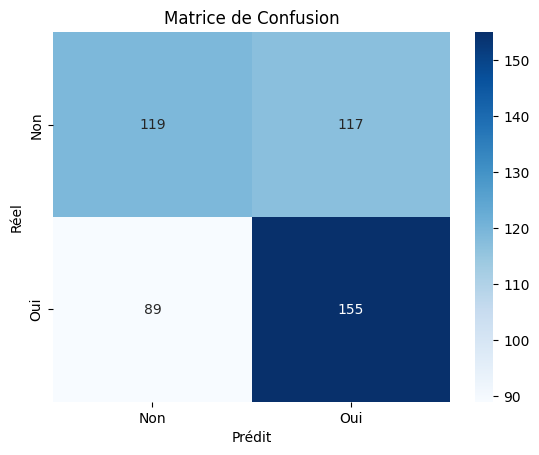

In [26]:
# Matrice de Confusion
print("\n--- Matrice de Confusion ---")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

On en déduit que le modèle produit plus de faux négatifs que de vrais négatifs

In [27]:
# Rapport détaillé
print("\n--- Rapport de Classification ---")
print(classification_report(y_test, y_pred))


--- Rapport de Classification ---
              precision    recall  f1-score   support

           0       0.57      0.50      0.54       236
           1       0.57      0.64      0.60       244

    accuracy                           0.57       480
   macro avg       0.57      0.57      0.57       480
weighted avg       0.57      0.57      0.57       480



Pour améliorer les performances, il nous faut déterminer les hyperparamètres optimaux

# 5.Recherche des meilleurs hyperparamètres 

In [28]:
# 1. Définition des hyperparamètres à tester pour les KNN
param_grid = {
    'n_neighbors': range(3, 15), # Nombre de voisins (k)
    'weights': ['uniform', 'distance'],  # Pondération des voisins
    'metric': ['euclidean', 'manhattan']  # Métrique de distance
}

# Définition du modèle
model = KNeighborsClassifier()

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,               # 5 folds de validation croisée
    scoring='accuracy',  # Métrique d'évaluation
    n_jobs=-1           # Utilisation de tous les cœurs CPU
)

# Exécution de la recherche
grid_search.fit(X_train, y_train)  # X = données originales, y = cible

# Résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score (accuracy) :", grid_search.best_score_)

Meilleurs hyperparamètres : {'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
Meilleur score (accuracy) : 0.6260416666666666


In [29]:
# 2. Définition des hyperparamètres à tester pour le Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Définition du modèle
model = RandomForestClassifier(random_state=42) 

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid_rf,
    cv=5,               # 5 folds de validation croisée
    scoring='accuracy',  # Métrique d'évaluation
    n_jobs=-1           # Utilisation de tous les cœurs CPU
)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

# Résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score (accuracy) :", grid_search.best_score_)


Meilleurs hyperparamètres : {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Meilleur score (accuracy) : 0.6671875


In [33]:
# 3. Définition des hyperparamètres à tester pour le XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Définition du modèle
model = XGBClassifier(random_state=42) 

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid_xgb,
    cv=5,               # 5 folds de validation croisée
    scoring='accuracy',  # Métrique d'évaluation
    n_jobs=-1           # Utilisation de tous les cœurs CPU
)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

# Résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score (accuracy) :", grid_search.best_score_)


Meilleurs hyperparamètres : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Meilleur score (accuracy) : 0.6817708333333334


Meilleur modèle : XGBoost

In [38]:
# Evaluation de ce modèle avec les meilleurs hyperparamètres
model = XGBClassifier(**grid_search.best_params_, random_state=42)
model= model.fit(X_train, y_train)  
y_pred = model.predict(X_test)

# Calcul des métriques
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
f1 = round(f1_score(y_test, y_pred)*100, 2)

# Affichage structuré
print("\n--- Métriques de Performance (%) ---")
print(f"Accuracy         : {accuracy}%")
print(f"Recall (Sensibilité) : {recall}%")
print(f"Précision        : {precision}%")
print(f"F1-Score         : {f1}%")


--- Métriques de Performance (%) ---
Accuracy         : 66.88%
Recall (Sensibilité) : 75.82%
Précision        : 64.91%
F1-Score         : 69.94%



--- Matrice de Confusion ---


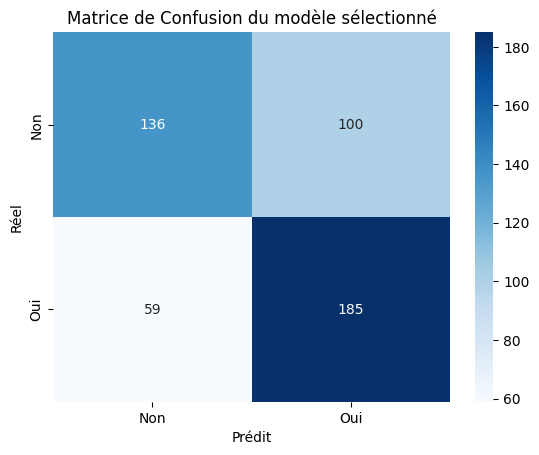

In [ ]:
# Matrice de Confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion du modèle sélectionné')
plt.show()

# 6. Analyse critique des résultats

### 1. Quels modèles fonctionnent le mieux ? Pourquoi ?
Il obtient la meilleure accuracy (66.88 %).

Il a le meilleur rappel (75.82 %), ce qui signifie qu’il détecte la majorité des cas positifs.

Son F1-Score (69.94 %) est également le plus élevé, ce qui montre un bon équilibre entre précision et rappel.

* RAISONS:
Il gère très bien les données non linéaires et les interactions entre variables.

Il bénéficie d’un réglage fin des hyperparamètres (GridSearch) : n_estimators=300, max_depth=10

Il est plus robuste que Random Forest sur des données complexes ou déséquilibrées.

### 2.  Les limites du modèle ? Des données ?
* Limites des modèles :
Random Forest est bon mais moins performant que XGBoost et peut sous-performer si les relations entre variables sont complexes ou si les classes sont déséquilibrées.


KNN : très sensible à :la normalisation des données,le bruit dans les features,les projections comme PCA qui altèrent la structure des distances.

XGBoost :Plus long à entraîner et plus complexe à interpréter si on ne fait pas d’analyse des features importantes.


* Limites des données :
Potentiel déséquilibre entre les classes : cela peut fausser l’accuracy et rendre certains modèles moins efficaces.

Qualité des variables : si certaines variables sont peu discriminantes ou bruitées, cela peut pénaliser tous les modèles.

Manque de données contextuelles ou métiers : des variables pertinentes peuvent manquer, limitant le pouvoir prédictif.

### 3. Interprétation des Métriques (après optimisation)
Recall élevé (75.8 % pour XGBoost) : le modèle est très bon pour détecter les vrais cas positifs.

Précision correcte (64.9 %) : certains faux positifs sont présents, mais le compromis reste acceptable.

F1-score élevé (~70 %) montre que le modèle est globalement fiable.

### 4) signification de  bonne ou mauvaise précision

* Une bonne précision évite de cibler des clients non intéressés ce qui permet une économie de budget et atteindre une précision élevée sans sacrifier le rappel.
* Une mauvaise précision : Campagnes marketing peu efficaces (trop de faux positifs).